<a href="https://colab.research.google.com/github/Wojak27/TDDE01Labs/blob/master/Convoluted_denoiser_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-datasets tensorflow

# setup ngrok to run tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-11-18 13:38:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 50.19.92.252, 52.203.65.11, 3.223.119.4, ...
Connecting to bin.equinox.io (bin.equinox.io)|50.19.92.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.11’

ngrok-stable-linux- 100%[===================>]  13.13M  6.57MB/s    in 2.0s    

2019-11-18 13:38:45 (6.57 MB/s) - ‘ngrok-stable-linux-amd64.zip.11’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
# this will make sure that we don't share the GPU memory with other users
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.1 GB  | Proc size: 156.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
# run tensorboard
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c24aaa7c.ngrok.io


In [0]:
import tensorflow as tf
#tf.enable_eager_execution()

batch_size = 2000

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# import cifar-10 dataset
#import tensorflow_datasets as tfds
# See available datasets
#print(tfds.list_builders())

#data = tfds.load(name="cifar10")
#train_data, test_data = data['train'], data['test']
num_of_training_samples = 9000
from tensorflow.keras import datasets
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = train_images[:num_of_training_samples]


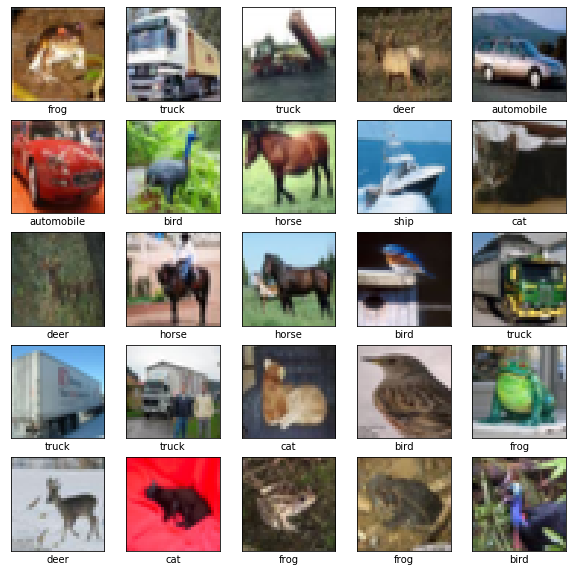

(32, 32, 3)


In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()
print(train_images[0].shape)


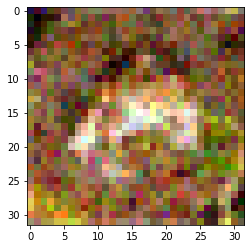

In [0]:
import skimage
image = skimage.util.random_noise(train_images[0], mode='gaussian', seed=None, clip=True)
import matplotlib.pyplot as plt

plt.imshow(image)

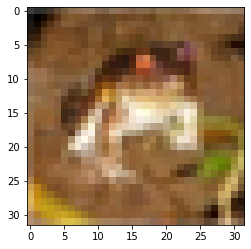

In [0]:
plt.imshow(train_images[0])

In [0]:
# For better debugging
# tf.tf.enable_eager_execution()

#tf.reset_default_graph() # clear the graph from variables
# Paceholder
x = tf.placeholder(tf.float32, shape=[None,32,32,3])

In [0]:
# the noising function helper
def noise_images(images):
    arr = []
    for image in images:
        arr.append(get_noisy_image(image))
    return arr

In [0]:
# the noising function 
def get_noisy_image(img):
    import skimage
    image = skimage.util.random_noise(img, mode='gaussian', seed=None, clip=True)
    return image

In [0]:
# Helper
#tf.executing_eagerly()
# Init weights
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1) # trunculated normal distribution
    return tf.Variable(init_random_dist)

In [0]:
#Init bias
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
#Conv2d
def conv2d(x,W, layer_name="default_conv2d"):
    # x --> [batch, Height, Width, Channels]
    # W --> [filter Height, filter Width, Channels In, Channels Out]
    # this is a kind of a wrapper around the standard tensorflow function
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding = "SAME") #padding, one is valid and one is same

In [0]:

# Pooling
def max_pool_2by2(x, layer_name="defaultmax_pool_2by2"):
    #x -->[batch, H, W, c]
    # ksize is the size of the window for the each dimension of the input tensor
    # stride is the stride of the sliding widow for each dimension of the input tensor2
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [0]:
# CONVOLUTIONAL LAYER
def convolutional_layer(input_x, shape, layer_name="default_convolutional_layer"):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(tf.add(conv2d(input_x,W),b), name=layer_name) 

In [0]:
# Normal layer (fully connected)
def normal_full_layer(input_layer, size, layer_name="default"):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W)+b

In [0]:
# Deconvolutional layer upskales the image so that he output will be 
# batch_size = batch_size
# output_width = input_width*2,
# output_height = input_height*2 
# channels = input_channels/2 

def deconv2d(input, out_shape, name="default_deconv2d"):
    strides=[1, 2, 2, 1]
    input_shape = input.get_shape().as_list()
    with tf.variable_scope(name) as scope:
        W1_1 = tf.get_variable("w", [5,5, out_shape[-1], input_shape[-1]],
                            initializer=tf.random_normal_initializer(stddev=0.02))
        
        dyn_input_shape = tf.shape(input)
        batch_size = dyn_input_shape[0]

        output_shape = tf.stack([batch_size, out_shape[1], out_shape[2], out_shape[3]])
    
        output = tf.nn.conv2d_transpose(input, W1_1, output_shape, strides, padding="SAME")

        return output

In [0]:
# And this is where we actually create the new Conv neural network!
# Paceholder

# Layers
#x_image = tf.reshape(x,[-1,32,32,1])
#x.get_shape()
# CREATING LAYERS
skips = []
# first convolution with 5x5 filter and pooling. Feature image size: 16x16
# num of features 32
n = convolutional_layer(x,shape=[5,5,3,32], layer_name="convolutional_layer_1")
skips.append(n)
n = max_pool_2by2(n)
skips.append(n)

# second convolution and pooling. Feature image size: 8x8
# num of features 64
n = convolutional_layer(n, shape=[5,5,32,64], layer_name="convolutional_layer_2")
#n = tf.nn.dropout(n, keep_prob=0.8)
n = max_pool_2by2(n)
#skips.append(n)

# third convolution and pooling. Feature image size: 4x4
# num of features 64
n = convolutional_layer(n, shape=[5,5,64,128], layer_name="convolutional_layer_3")
#n = tf.nn.dropout(n, keep_prob=0.8)
n = max_pool_2by2(n)


# upsampling. Feature image size: 16x16
# num of features 32
n = deconv2d(n, [batch_size,8,8,64], "deconv2d_layer2")
n = convolutional_layer(n, shape=[1,1,64,64], layer_name="convolutional_layer_4")
n = convolutional_layer(n, shape=[1,1,64,64], layer_name="convolutional_layer_5")
# upsampling. Feature image size: 32x32
# num of features 1
n = deconv2d(n, [batch_size,16,16,32], "deconv2d_layer3")
n = tf.concat([n, skips.pop()], axis=3)
n = convolutional_layer(n, shape=[5,5,64,32], layer_name="convolutional_layer_6")
n = convolutional_layer(n, shape=[1,1,32,32], layer_name="convolutional_layer_7")
n = deconv2d(n, [batch_size,32,32,32], "deconv2d_layer5")
n = tf.concat([n, skips.pop()], axis=3)

n = convolutional_layer(n, shape=[5,5,64,32], layer_name="convolutional_layer_8")
n = convolutional_layer(n, shape=[5,5,32,3], layer_name="convolutional_layer_9")
n = convolutional_layer(n, shape=[1,1,3,3], layer_name="convolutional_layer_10")
n = convolutional_layer(n, shape=[1,1,3,3], layer_name="convolutional_layer_11")


# Setting some learning rate
learning_rate = 0.001

# loss function
loss = tf.reduce_mean(tf.square(n-x))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

# Train, or in other words
# use the optimizer to minimize the loss function
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# init the saver for the model
saver = tf.train.Saver()
#run_network(5)

num_epochs = 150

# init session 
with tf.Session() as sess:
    sess.run(init)

    #run for epochs: num_epochs
    for epoch in range(num_epochs):
        num_batches = len(train_images) // batch_size# batch_size

        #run for number of iterations
        for iteration in range(num_batches):

            
            #sess.run(train, feed_dict = {x:train_images}) #training on clean data
            X_noisy_batch = noise_images(train_images) # training on noisy data

            sess.run(train, feed_dict = {x:X_noisy_batch}) # training on noisy data

        # compare with the original (or not) images    
        training_loss = loss.eval(feed_dict={x:train_images})

        print("EPOCH: {} LOSS: {}".format(epoch, training_loss))

    saver.save(sess, "./example_stacked_autoencoder.ckpt")
    file_writer = tf.summary.FileWriter('./log', sess.graph)

EPOCH: 0 LOSS: 0.19886329770088196
EPOCH: 1 LOSS: 0.18477188050746918
EPOCH: 2 LOSS: 0.18069785833358765
EPOCH: 3 LOSS: 0.17280063033103943
EPOCH: 4 LOSS: 0.16371244192123413
EPOCH: 5 LOSS: 0.15453244745731354
EPOCH: 6 LOSS: 0.1461411714553833
EPOCH: 7 LOSS: 0.14016547799110413
EPOCH: 8 LOSS: 0.13226176798343658
EPOCH: 9 LOSS: 0.12415775656700134
EPOCH: 10 LOSS: 0.11639737337827682
EPOCH: 11 LOSS: 0.10912299901247025
EPOCH: 12 LOSS: 0.10159720480442047
EPOCH: 13 LOSS: 0.09442569315433502
EPOCH: 14 LOSS: 0.08812085539102554
EPOCH: 15 LOSS: 0.08078376203775406
EPOCH: 16 LOSS: 0.07451392710208893
EPOCH: 17 LOSS: 0.06768457591533661
EPOCH: 18 LOSS: 0.0610487200319767
EPOCH: 19 LOSS: 0.054844532161951065
EPOCH: 20 LOSS: 0.048976220190525055
EPOCH: 21 LOSS: 0.042487237602472305
EPOCH: 22 LOSS: 0.036881767213344574
EPOCH: 23 LOSS: 0.03249039873480797
EPOCH: 24 LOSS: 0.02745707333087921
EPOCH: 25 LOSS: 0.022958246991038322
EPOCH: 26 LOSS: 0.020155012607574463
EPOCH: 27 LOSS: 0.0166763085871934

In [0]:
num_test_images = 16
keep_probability = 1

test = test_images[:num_test_images]
test_noisy_batch = noise_images(test) # training on noisy data
with tf.Session() as sess:
    saver.restore(sess, "./example_stacked_autoencoder.ckpt")
    results = n.eval(feed_dict={x:test_noisy_batch})

INFO:tensorflow:Restoring parameters from ./example_stacked_autoencoder.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

16


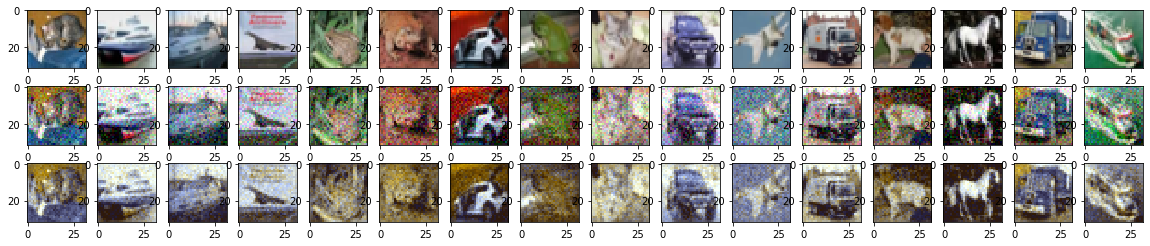

In [0]:
# Compare original images with their reconstructions
f, a = plt.subplots(3,16, figsize=(20,4))
print(len(results))
for i in range(num_test_images):
    a[0][i].imshow(np.reshape(test_images[i], (32,32,3))) # Original
    a[1][i].imshow(np.reshape(test_noisy_batch[i], (32,32,3))) # noised
    a[2][i].imshow(results[i]) # output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.5745682  0.51155317 0.34345123]
  [0.57435286 0.5015852  0.30609322]
  [0.54133296 0.4455589  0.19909704]
  ...
  [0.5417061  0.42919582 0.13541883]
  [0.47360614 0.3958105  0.22842935]
  [0.43706423 0.36624232 0.23384629]]

 [[0.57447124 0.48506808 0.2426515 ]
  [0.4972943  0.4119181  0.21323583]
  [0.5176246  0.43101978 0.22034389]
  ...
  [0.5898193  0.47208405 0.14339346]
  [0.47362554 0.38651177 0.19286606]
  [0.45321319 0.3977827  0.30197915]]

 [[0.5591699  0.4592555  0.19364196]
  [0.52484787 0.41110736 0.12093812]
  [0.5515919  0.45018715 0.18355435]
  ...
  [0.56438136 0.43588647 0.08755282]
  [0.45646113 0.38581106 0.24575928]
  [0.46553856 0.37445518 0.17301777]]

 ...

 [[0.3752749  0.39328712 0.5371348 ]
  [0.32453278 0.34131628 0.5029957 ]
  [0.24321024 0.24209651 0.38747275]
  ...
  [0.3751545  0.40307868 0.57490647]
  [0.27942413 0.2862802  0.43891647]
  [0.2956197  0.30604008 0.46192312]]

 [[0.36754715 0.37905645 0.50782347]
  [0.29282862 0.30263475 0.45795825]


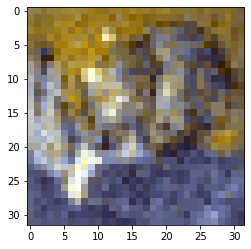

In [0]:
print(results[0])
plt.imshow(results[0])